In [18]:
import yfinance as yf
import pandas as pd
import datetime as datetime
from datetime import timedelta
import seaborn as sns
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pandas import Timestamp
import pickle
from pmdarima import auto_arima
from sklearn import metrics

In [19]:
df_truth = pd.read_csv('../Data/data_recommender_truth.csv')

In [20]:
df_msft = yf.Ticker('MSFT').history(period='3y')

In [21]:
df_msft['Open_pct_change'] = df_msft['Open'].pct_change(periods=1)*100
df_msft['Close_pct_change'] = df_msft['Close'].pct_change(periods=1)*100

In [22]:
df_msft = df_msft[df_msft['Open_pct_change'].notnull()]

In [23]:
prd = -int(len(df_msft)*0.33)

In [24]:
def train_predict_arima(df, prd):
    #prd determine variable of percent used for test train. 0.33 one third of data is test.
    #split data using variable defined 
    train_data, test_data = df[0:prd],df[prd:]
    
    #external variable for ARIMAX
    exoX   =  df[['Close_pct_change']]
    exotrain, exotest = exoX[0:prd], exoX[prd:]
    
    #ARIMA VARIABLE FOR SEASONALITY
    m=1
    
    ######################## model training ###########################################
    print(f'  SARIMAX m = {str(m)}') 
    model = auto_arima(train_data['Open_pct_change'], exogenous = exotrain , seasonal=True, m = m,
                       d=None,D=None, trace=True, stepwise=True)

    print("-"*100)
    #output summary of model
    #model.summary()

    #forcast 
    forecast = model.predict(n_periods=-prd,exogenous =exotest, return_conf_int=False)
    

    #adjust index of predictions  
    #index shift due to predictions start from 2/3 of data subtract the -1/3 (to add) 
    dif = len(train_data)-prd        #-1 due to train_data starting at 0
    
    forecast  =   pd.DataFrame(forecast, columns=['open_pred'])
    forecast["new_index"] = range(len(train_data), dif)
    forecast  =   forecast.set_index("new_index")
    
    return model, forecast

In [25]:
model, forecast = train_predict_arima(df_msft, prd)

  SARIMAX m = 1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1880.766, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2016.034, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1964.997, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1886.178, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2015.849, Time=0.07 sec


/Users/sohnnick/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/sohnnick/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/sohnnick/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/sohnnick/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1878.889, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1877.102, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=1878.849, Time=0.09 sec


/Users/sohnnick/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/sohnnick/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1878.117, Time=0.07 sec


/Users/sohnnick/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/sohnnick/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/sohnnick/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/sohnnick/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1880.196, Time=0.23 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1875.994, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1886.470, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1877.774, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1877.739, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1877.106, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1879.714, Time=0.07 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 1.363 seconds
----------------------------------------------------------------------------------------------------


/Users/sohnnick/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/sohnnick/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/sohnnick/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/sohnnick/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/sohnnick/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(se

In [29]:
len(df_msft)

757

In [44]:
recs = [None]*(len(df_msft)+prd+1) + list(forecast['open_pred'])
recs.pop()

2.0917959801734014

In [45]:
df_msft['pct_pred'] = recs

/var/folders/76/hqb6395n2gs2s14wlzvt4x5r0000gn/T/ipykernel_77490/1017623151.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_msft['pct_pred'] = recs


In [46]:
df_msft = df_msft[df_msft['pct_pred'].notnull()]

In [50]:
rmse = mean_squared_error(df_msft['Open_pct_change'], df_msft['pct_pred'], squared=False)
mape = np.mean([abs((x-y)/x) for x,y in zip(list(df_msft['Open_pct_change']), list(df_msft['pct_pred']))])

print('rmse: {0} || mape: {1}'.format(rmse, mape))

rmse: 1.2892462084688834 || mape: 3.7065353850883076


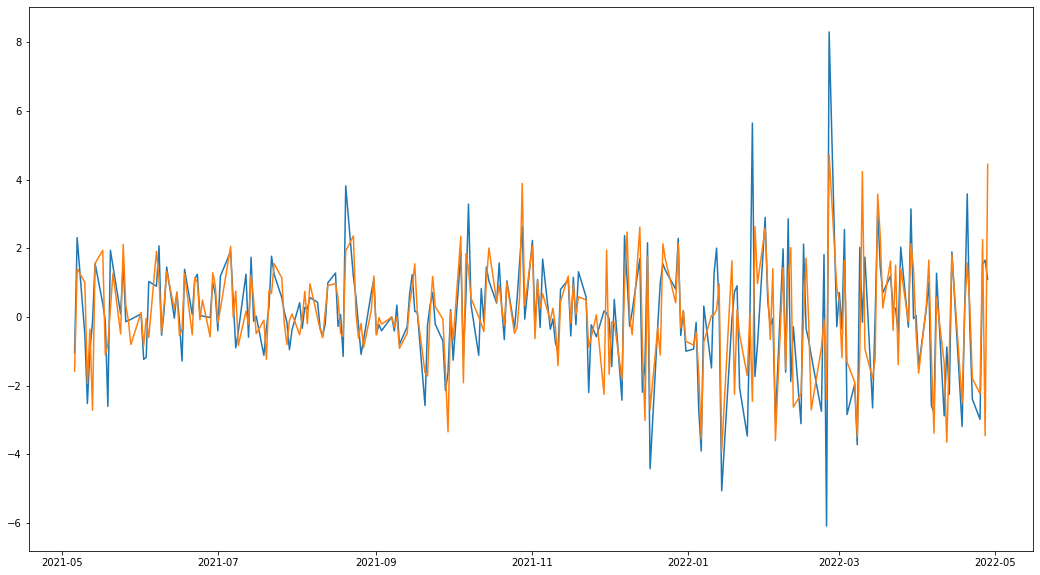

In [54]:
plt.figure(figsize=(18,10))
plt.plot(df_msft.index, df_msft['Open_pct_change'])
plt.plot(df_msft.index, df_msft['pct_pred'])

In [69]:
truth_rec = []
pred_rec = []

truth_pct_change = list(df_msft['Open_pct_change'])
pred_pct_change = list(df_msft['pct_pred'])

for i in range(len(truth_pct_change)):
    if truth_pct_change[i] <= 1 and truth_pct_change[i] >= -1:
        #print(‘hold’)
        truth_rec.append('hold')
    elif truth_pct_change[i] > 1:
        #print(‘sell’)
        truth_rec.append('buy')
    elif truth_pct_change[i] < -1:
        #print(‘buy’)
        truth_rec.append('sell')

    if pred_pct_change[i] <= 1 and pred_pct_change[i] >= -1:
        #print(‘hold’)
        pred_rec.append('hold')
    elif pred_pct_change[i] > 1:
        #print(‘sell’)
        pred_rec.append('buy')
    elif pred_pct_change[i] < -1:
        #print(‘buy’)
        pred_rec.append('sell')

In [70]:
metrics.accuracy_score(truth_rec, pred_rec)

0.7298387096774194

In [71]:
df_msft['truth_rec'] = truth_rec
df_msft['pred_rec'] = pred_rec

/var/folders/76/hqb6395n2gs2s14wlzvt4x5r0000gn/T/ipykernel_77490/1397973030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_msft['truth_rec'] = truth_rec
/var/folders/76/hqb6395n2gs2s14wlzvt4x5r0000gn/T/ipykernel_77490/1397973030.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_msft['pred_rec'] = pred_rec


In [72]:
df_test = df_msft[df_msft['pred_rec'] != 'hold']

In [73]:
df_test

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Open_pct_change,Close_pct_change,pct_pred,truth_rec,pred_rec
Date,,,,,,,,,,,,
2021-05-06,244.458767,247.841220,242.712993,247.712265,26491100,0.0,0,-1.047939,1.322675,-1.573600,sell,sell
2021-05-07,250.112734,252.245372,249.140656,250.420242,27032900,0.0,0,2.312851,1.093195,1.407117,buy,buy
2021-05-10,248.843081,249.696133,245.123379,245.182892,29299900,0.0,0,-0.507632,-2.091425,1.010375,hold,buy
2021-05-11,242.574136,244.607576,240.610138,244.240555,33641600,0.0,0,-2.519236,-0.384340,-1.932979,sell,sell
2021-05-13,239.846348,243.615649,239.469414,241.066406,29624300,0.0,0,-0.152790,1.686185,-2.713822,hold,sell
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-22,281.679993,283.200012,273.380005,274.029999,29379300,0.0,0,-2.391016,-2.414444,-1.791285,sell,sell
2022-04-25,273.290009,281.109985,270.769989,280.720001,35678900,0.0,0,-2.978552,2.441339,-2.231526,sell,sell
2022-04-26,277.500000,278.359985,270.000000,270.220001,46518400,0.0,0,1.540485,-3.740382,2.256385,buy,buy


In [74]:
# pct_pred is made from the day before
# pct_pred references the predicted price for that day

# truth rec is what actually happened and if we knew the truth the day before, we would buy/sell